# Latent Vector Autoregressive Model

This is an experimental example of a Latent Vector Autoregressive Model (LVAR).

In [214]:
using RxInfer, Random, LinearAlgebra

At first let us define auxiliary functions for priors, `c` and `b` variables

In [717]:
function generate_ar_process(order, θ, n_samples; σ²=1.0)
    x = zeros(n_samples)
    # Initialize with random noise
    x[1:order] = randn(order) * sqrt(σ²)
    
    for t in (order+1):n_samples
        # AR equation: x[t] = θ₁x[t-1] + θ₂x[t-2] + ... + θₚx[t-p] + ε[t]
        x[t] = sum(θ[i] * x[t-i] for i in 1:order) + randn() * sqrt(σ²)
    end
    return x
end

# Set random seed for reproducibility
Random.seed!(42)

# Define orders for each process
orders = 10 .* ones(Int, 20)
n_samples = 150
n_missing = 50

n_ar_processes = length(orders)
processes = []

# Generate AR parameters and data for each process
for (i, order) in enumerate(orders)
    # Generate stable AR parameters (using a simple method)
    θ = 0.5 .^ (1:order)  # This ensures stability by having decreasing coefficients
    
    # Generate the AR process
    x = generate_ar_process(order, θ, n_samples)
    push!(processes, x)
end

# Convert to the format needed for the model
true_data = [[processes[j][i] for j in 1:n_ar_processes] for i in 1:n_samples]
observations = Any[[true_data[i][j] .+ randn()*0.1 for j in 1:n_ar_processes] for i in 1:n_samples]

training_set = deepcopy(observations[1:n_samples-n_missing])

# Extend observations with missing values
for i in n_samples-n_missing:n_samples
    push!(training_set, missing)
end

In [718]:
function form_priors(orders)
    priors = (x = [], γ = [], θ = [])
    for k in 1:length(orders)
        push!(priors[:γ], GammaShapeRate(1.0, 1.0))
        push!(priors[:x], MvNormalMeanPrecision(zeros(orders[k]), diageye(orders[k])))
        push!(priors[:θ], MvNormalMeanPrecision(zeros(orders[k]), diageye(orders[k])))
    end
    return priors
end

function form_c_b(y, orders)
    c = Any[]
    b = Any[]
    for k in 1:length(orders)
        _c = ReactiveMP.ar_unit(Multivariate, orders[k])
        _b = zeros(length(y[1])); _b[k] = 1.0
        push!(c, _c)
        push!(b, _b)
    end
    return c, b
end

form_c_b (generic function with 1 method)

Next, we define a sub-model for a single AR-process

In [719]:
@model function AR_sequence(x, index, length, priors, order)
    γ ~ priors[:γ][index]
    θ ~ priors[:θ][index]
    x_prev ~ priors[:x][index]
    for i in 1:length
        x[index, i] ~ AR(x_prev, θ, γ) where {
            meta = ARMeta(Multivariate, order, ARsafe())
        }
        x_prev = x[index, i]
    end
end

Next, we define a tricky dot sequence

In [720]:
@model function dot_sequence(out, k, i, orders, x, c, b)
    if k === length(orders)
        out ~ b[k] * dot(c[k], x[k, i])
    else 
        next ~ dot_sequence(k = k + 1, i = i, orders = orders, x = x, c = c, b = b)
        out  ~ b[k] * dot(c[k], x[k, i]) + next
    end
end

And here is our final model spec

In [721]:
@model function LVAR(y, orders)

    priors   = form_priors(orders)
    c, b     = form_c_b(y, orders)
    y_length = length(y)
    
    local x # `x` is being initialized in the loop within submodels
    for k in 1:length(orders)
        x ~ AR_sequence(index  = k, length = y_length, priors = priors, order  = orders[k])
    end

    τ ~ GammaShapeRate(1.0, 1.0)
    for i in 1:y_length
        μ[i] ~ dot_sequence(k = 1, i = i, orders = orders, x = x, c = c, b = b)
        y[i] ~ MvNormalMeanScalePrecision(μ[i], τ)
    end
end

In [722]:
@constraints function lvar_constraints()
    for q in AR_sequence
        # This requires patch in GraphPPL though, see https://github.com/ReactiveBayes/GraphPPL.jl/issues/262
        # A workaround is to use `constraints = MeanField()` in the `infer` function and initializing `q(x)` instead of `μ(x)`
        q(x, x_prev, γ, θ) = q(x, x_prev)q(γ)q(θ)
    end
    q(μ, τ) = q(μ)q(τ)
end

lvar_constraints (generic function with 1 method)

In [723]:
@initialization function lvar_init(orders)
    # This is a problem still
    for init in AR_sequence
        q(γ) = GammaShapeRate(1.0, 1.0) 
        q(θ) = MvNormalMeanPrecision(zeros(orders[1]), diageye(orders[1])) # `orders[1]` is sad... needs to be fixed
    end
    q(τ) = GammaShapeRate(1.0, 1.0)
    μ(x) = MvNormalMeanPrecision(zeros(orders[1]), diageye(orders[1]))
end

lvar_init (generic function with 1 method)

In [724]:
mresult = infer(
    model          = LVAR(orders = orders), 
    data           = (y = training_set, ), 
    constraints    = lvar_constraints(), 
    initialization = lvar_init(orders), 
    returnvars = KeepLast(), 
    options = (limit_stack_depth = 100, ),
    showprogress = true,
    iterations = 50,
    free_energy = false,
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


Inference results:
  Posteriors       | available for (μ, τ, x)
  Predictions      | available for (y)


In [725]:
using Plots

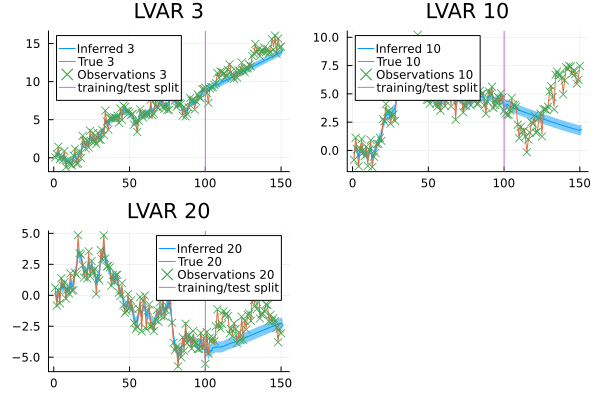

In [726]:
index = 3
plt1 = plot()
plot!(plt1, getindex.(mean.(mresult.predictions[:y][end]), index), ribbon = getindex.(diag.(cov.(mresult.predictions[:y][end])), index), label = "Inferred $(index)")
plot!(plt1, getindex.(true_data, index), label = "True $(index)")
scatter!(getindex.(observations, index), label = "Observations $(index)", marker=:xcross)
vline!([n_samples-n_missing], label="training/test split")
plot!(plt1, title = "LVAR $(index)")

index = 10
plt2 = plot()
plot!(plt2, getindex.(mean.(mresult.predictions[:y][end]), index), ribbon = getindex.(diag.(cov.(mresult.predictions[:y][end])), index), label = "Inferred $(index)")
plot!(plt2, getindex.(true_data, index), label = "True $(index)")
scatter!(getindex.(observations, index), label = "Observations $(index)", marker=:xcross)
vline!([n_samples-n_missing], label="training/test split")
plot!(plt2, title = "LVAR $(index)")

index = 20
plt3 = plot()
plot!(plt3, getindex.(mean.(mresult.predictions[:y][end]), index), ribbon = getindex.(diag.(cov.(mresult.predictions[:y][end])), index), label = "Inferred $(index)")
plot!(plt3, getindex.(true_data, index), label = "True $(index)")
scatter!(getindex.(observations, index), label = "Observations $(index)", marker=:xcross)
vline!([n_samples-n_missing], label="training/test split")
plot!(plt3, title = "LVAR $(index)")

plot(plt1, plt2, plt3)